# Домашнее задание 4

Задание по итогам четвертого вебинара.

1.	Необходимо доработать обучение нейросети, что мы разбирали на уроке.(Посмотрите чего не хватает в процессе обучения и подготовки данных)

2.	Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на губы(т.е. 2 класса: губы/не губы).

3.	И затем обучить Модель на выбор из segmentation_models_pytorch

4.	*(Усложненное задание) Переделайте архитектуру декодера Unet так, как в этой работе https://www.ics.uci.edu/~haoyum3/papers/slides_icivc.pdf. Эта тема пересекается с темой о второго вебинара о LSTM-сетях. И попробуйте обучить получившуюся нейронную сеть.



**Подключим необходимые библиотеки**

In [1]:
import numpy as np 
import pandas as pd 

import os 
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_similarity_score as jsc

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

import matplotlib.pyplot as plt 

**Загрузим датасет**

In [44]:
df1 = pd.read_csv('E:\ML\set-lipstick-original\list.csv', delimiter=',')
df1.dataframeName = 'list.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 28594 rows and 9 columns


In [45]:
df1.info

<bound method DataFrame.info of                 filename  width  height class  xmin  ymin  xmax  ymax  \
0      image00000001.jpg   1280     720  Lips   661   394   776   444   
1      image00000002.jpg   1280     720  Lips   557   336   682   392   
2      image00000003.jpg   1280     720  Lips   553   369   684   427   
3      image00000004.jpg   1280     720  Lips   555   351   681   408   
4      image00000005.jpg   1280     720  Lips   555   351   680   407   
...                  ...    ...     ...   ...   ...   ...   ...   ...   
28589  image00028590.jpg   1280     720  Lips   657   347   817   450   
28590  image00028591.jpg   1280     720  Lips   713   325   884   388   
28591  image00028592.jpg   1280     720  Lips   659   401   808   488   
28592  image00028593.jpg   1280     720  Lips   689   334   839   431   
28593  image00028594.jpg   1280     720  Lips   657   381   817   476   

                   mask  
0      mask00000001.png  
1      mask00000002.png  
2      mask00

**Выполним подготовку датасета**

In [175]:
rootMask = 'E:\\ML\\set-lipstick-original\\mask\\'
rootJPG = 'E:\\ML\\set-lipstick-original\\720p\\'
lipsJPG = []
lipsMask = []
for ind in df1.index: 
    pathMask = rootMask + df1['mask'][ind]
    pathFilename = rootJPG + df1['filename'][ind]
    if os.path.exists(pathMask):
        lipsJPG.append(pathFilename)
        lipsMask.append(pathMask)

In [176]:
dfLips = pd.DataFrame(lipsJPG)

In [177]:
dfLips

,0
0,E:\ML\set-lipstick-original\720p\image00000001...
1,E:\ML\set-lipstick-original\720p\image00000002...
2,E:\ML\set-lipstick-original\720p\image00000003...
3,E:\ML\set-lipstick-original\720p\image00000004...
4,E:\ML\set-lipstick-original\720p\image00000005...
...,...
28535,E:\ML\set-lipstick-original\720p\image00028590...
28536,E:\ML\set-lipstick-original\720p\image00028591...
28537,E:\ML\set-lipstick-original\720p\image00028592...
28538,E:\ML\set-lipstick-original\720p\image00028593...


In [179]:
dfMask= pd.DataFrame(lipsMask)
dfMask

,0
0,E:\ML\set-lipstick-original\mask\mask00000001.png
1,E:\ML\set-lipstick-original\mask\mask00000002.png
2,E:\ML\set-lipstick-original\mask\mask00000003.png
3,E:\ML\set-lipstick-original\mask\mask00000004.png
4,E:\ML\set-lipstick-original\mask\mask00000005.png
...,...
28535,E:\ML\set-lipstick-original\mask\mask00028590.png
28536,E:\ML\set-lipstick-original\mask\mask00028591.png
28537,E:\ML\set-lipstick-original\mask\mask00028592.png
28538,E:\ML\set-lipstick-original\mask\mask00028593.png


**Теперь завернем эти два списка в DataFrame из библиотеки pandas. В итоге выведем первые пять записей из получившегося датафрейма:**

In [181]:
df = pd.DataFrame({'lipsJPG': lipsJPG, 'lipsMask': lipsMask})
# Отсортируем  датафрейм по значениям
df.sort_values(by='lipsJPG',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df.head(5))

                                             lipsJPG  \
0  E:\ML\set-lipstick-original\720p\image00000001...   
1  E:\ML\set-lipstick-original\720p\image00000002...   
2  E:\ML\set-lipstick-original\720p\image00000003...   
3  E:\ML\set-lipstick-original\720p\image00000004...   
4  E:\ML\set-lipstick-original\720p\image00000005...   

                                            lipsMask  
0  E:\ML\set-lipstick-original\mask\mask00000001.png  
1  E:\ML\set-lipstick-original\mask\mask00000002.png  
2  E:\ML\set-lipstick-original\mask\mask00000003.png  
3  E:\ML\set-lipstick-original\mask\mask00000004.png  
4  E:\ML\set-lipstick-original\mask\mask00000005.png  


In [210]:
class CustomDatasetFromImagesNew(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(Image.open(self.label_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        lab = torch.as_tensor(lab)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        lab = lab.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        lab = F.interpolate(input=lab, size=256, align_corners=False, mode='bicubic')
            
        
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [229]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера XxY float-значений
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (x, y, 3) -> (1, x, y, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, x, y, 3) -> (1, 3, x, y)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с XxY на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера XxY float-значений
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем 2 каналов масками нужных классов
        # Т.е. там, где губы - все пиксели 1 
        # если не принадлежат классу, и 0 если принадлежат 
        x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
        for i in range(1, 2):
            mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
            mask = np.where(mask == i, 255, 0)
            x = torch.as_tensor(mask).unsqueeze(0)
            x_out =  torch.cat((x_out,x),dim=0)    
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [223]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

In [230]:
# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

train_data_loader = DataLoader(train_data,batch_size=128,shuffle=True)
test_data_loader = DataLoader(train_data,batch_size=128,shuffle=False)

In [192]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [234]:
# создание модели
segmodel = smp.Unet()
segmodel = smp.Unet('resnet34', classes=2, activation='softmax').to(device)

In [235]:
optimizer = torch.optim.Adam(segmodel.parameters())

In [236]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =(2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        #print(score.sum())
        score =1 - score.sum() / num
        return score

In [237]:
criterion = SoftDiceLoss()

In [238]:
epoch_losses = []

for epoch in range(2):  # loop over the dataset multiple times
    epoch_loss = []
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = criterion(outputs,labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()

        # print statistics
        epoch_loss.append(loss.item())
        print(f'batch index : {i} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    time2 = time.time()
    print(f'Spend time for 1 epoch: {time2-time1} sec')
    
    epoch_losses.append(epoch_loss)

batch index : 0 | loss : 0.4681544303894043
batch index : 1 | loss : 0.470184862613678
batch index : 2 | loss : 0.3148726224899292
batch index : 3 | loss : 0.19990569353103638
batch index : 4 | loss : 0.24200987815856934
batch index : 5 | loss : 0.156694233417511
batch index : 6 | loss : 0.11450982093811035
batch index : 7 | loss : 0.09502863883972168
batch index : 8 | loss : 0.01946359872817993
batch index : 9 | loss : -0.3033846616744995
batch index : 10 | loss : -0.3476656675338745
batch index : 11 | loss : -0.056050658226013184
batch index : 12 | loss : -0.4258568286895752
batch index : 13 | loss : 0.08030122518539429
batch index : 14 | loss : -0.30430853366851807
batch index : 15 | loss : -0.20681452751159668
batch index : 16 | loss : -0.23529982566833496
batch index : 17 | loss : -0.31989502906799316
batch index : 18 | loss : -0.30347514152526855
batch index : 19 | loss : -0.6012346744537354
batch index : 20 | loss : -0.2327955961227417
batch index : 21 | loss : -0.27982544898986

KeyboardInterrupt: 

In [239]:
def get_orig(image):
    #image = images[0,:,:,:]
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

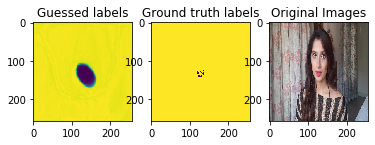

C:\Users\Kashe\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 432x288 with 0 Axes>

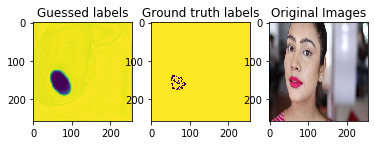

<Figure size 432x288 with 0 Axes>

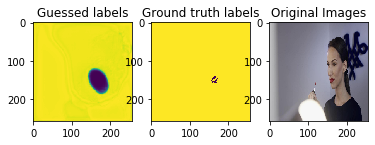

<Figure size 432x288 with 0 Axes>

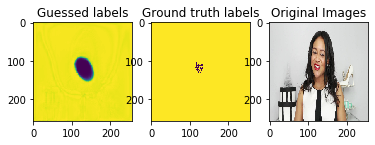

<Figure size 432x288 with 0 Axes>

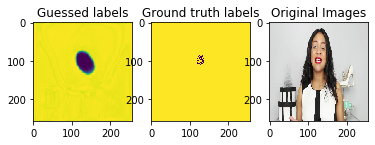

<Figure size 432x288 with 0 Axes>

In [240]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = segmodel(images[0])
    f, axarr = plt.subplots(1,3)

    axarr[0].imshow(outputs.detach().cpu().numpy()[0,0,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    original = get_orig(images[0][0,:,:,:])
    axarr[2].imshow(original)
    axarr[2].set_title('Original Images')
    
    plt.show()
    plt.gcf().show()
    if i>3:
        break